In [2]:
import torch 
import PIL
import cv2 
import matplotlib.pyplot as plt
from glob import glob
import h5py
import numpy as np

In [3]:
!ls ../itk_flex_qc/module-qc-nonelec-gui/src/module_qc_nonelec_gui/qc_tests/VISUAL_INSPECTION/model/model_PCB_PCB_RECEPTION/

AE_config.txt     AE_threshold.txt  data_process.json
AE_state.save     cluster.json


In [4]:
model_path = "../itk_flex_qc/module-qc-nonelec-gui/src/module_qc_nonelec_gui/qc_tests/VISUAL_INSPECTION/model/model_PCB_PCB_RECEPTION/"

In [5]:
from defect_detection import AE_cls, deepAE_load, get_pixels, emap_mean

In [6]:
ae_model = deepAE_load(model_path)

/Users/asopio/Documents/itk_flex_anomaly_detection/defect_detection/src/defect_detection/functions.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae.load_state_dict(to

In [7]:
img_fs = glob("data/testflex/*jpg")

In [8]:
img_fs

['data/testflex/tile_img_front_5.jpg',
 'data/testflex/tile_img_front_4.jpg',
 'data/testflex/tile_img_front_6.jpg',
 'data/testflex/tile_img_front_7.jpg',
 'data/testflex/tile_img_front_3.jpg',
 'data/testflex/tile_img_front_2.jpg',
 'data/testflex/tile_img_front_0.jpg',
 'data/testflex/tile_img_front_1.jpg',
 'data/testflex/tile_img_front_13.jpg',
 'data/testflex/tile_img_front_12.jpg',
 'data/testflex/tile_img_front_10.jpg',
 'data/testflex/tile_img_front_11.jpg',
 'data/testflex/tile_img_front_15.jpg',
 'data/testflex/tile_img_front_14.jpg',
 'data/testflex/tile_img_front_9.jpg',
 'data/testflex/tile_img_front_8.jpg']

In [9]:
from data_module import ImageDataset
from defect_detection import get_pixels, emap_mean

In [10]:
ds = ImageDataset('data/testflex')

In [11]:
img_rec = ae_model.forward(ds[0])

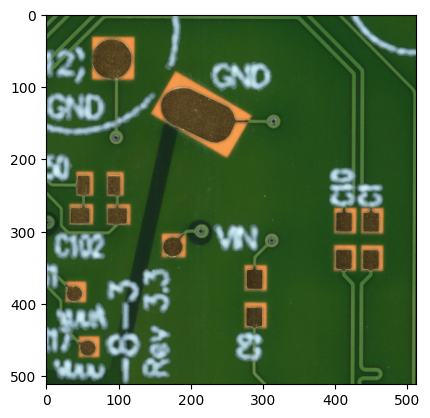

In [12]:
plt.imshow(ds[0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004886955..1.0174124].


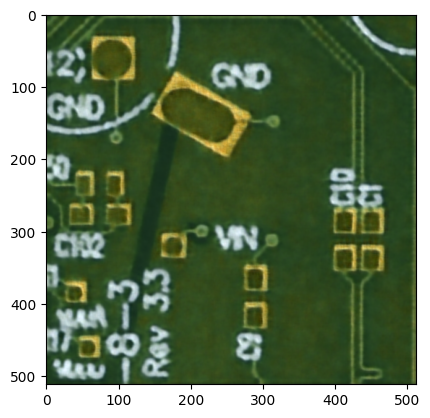

In [13]:
plt.imshow(img_rec.detach().permute(1,2,0))

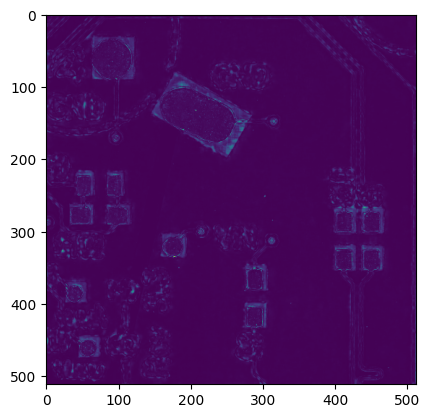

In [24]:
emap = emap_mean(img_rec, ds[0])
plt.imshow(emap)

In [25]:
from pathlib import Path
with Path.open(model_path + "cluster.json", "r") as f:
        clparam = eval(f.read())

pix_th = clparam["pix_th"]
clparam.pop("pix_th")

10

In [26]:
quantiles = np.quantile(emap, [0.9, 0.95, 0.99, 0.999])
quantiles

array([0.00545592, 0.00981728, 0.0211529 , 0.04264038])

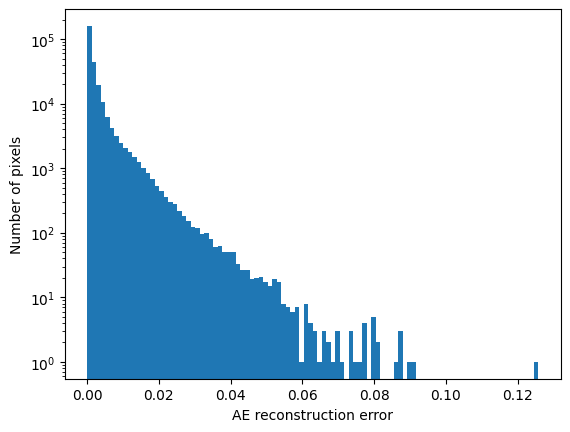

In [27]:
plt.hist(emap.flatten(), bins=100)
plt.ylabel("Number of pixels")
plt.xlabel("AE reconstruction error")
plt.semilogy()
plt.show()

In [28]:
thr = quantiles[1]
pixels = get_pixels(emap, thr, clparam, pix_th)
pixels

array([[  0, 186],
       [  0, 188],
       [  0, 189],
       ...,
       [511, 508],
       [511, 509],
       [511, 511]])

In [29]:
ds[-1].shape

torch.Size([3, 512, 512])

In [30]:
im_cr = ds[0].numpy()
anom_cl = pixels

# Generate anomaly clusters overlay
over_cl = np.zeros((im_cr.shape[1], im_cr.shape[2], 4), dtype=im_cr.dtype)
over_cl[:, :, 0][
    np.transpose(anom_cl)[0], np.transpose(anom_cl)[1]
] = 255  # red channel
over_cl[:, :, 2][
    np.transpose(anom_cl)[0], np.transpose(anom_cl)[1]
] = 255  # blue channel
over_cl[:, :, 3][
    np.transpose(anom_cl)[0], np.transpose(anom_cl)[1]
] = 255  # alpha channel (transparency)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


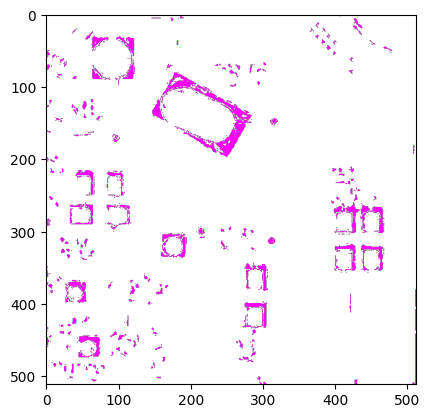

In [31]:
# Plot anomaly clusters overlay
plt.imshow(over_cl)